In [23]:
from pathlib import Path
import os

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from src import analysis
analysis.__all__

['plot_shap_values',
 'EventDetector',
 'SPI',
 'ZScoreIndex',
 'PercentNormalIndex',
 'DroughtSeverityIndex',
 'ChinaZIndex',
 'DecileIndex',
 'AnomalyIndex']

In [24]:
# make dummy data for the EventDetector and Indices
import numpy as np
import pandas as pd
import xarray as xr

# make the directory
dummy_data_path = Path('data/dummy')
if not dummy_data_path.exists():
    dummy_data_path.mkdir(exist_ok=True, parents=True)

# build the dataset
def _make_dataset(size, variable_name='VHI', lonmin=-180.0, lonmax=180.0,
                  latmin=-55.152, latmax=75.024, add_times=True, const=False,
                  start_date='1999-01-01', end_date='2001-12-31'):

    lat_len, lon_len = size
    # create the vector
    longitudes = np.linspace(lonmin, lonmax, lon_len)
    latitudes = np.linspace(latmin, latmax, lat_len)

    dims = ['lat', 'lon']
    coords = {'lat': latitudes,
              'lon': longitudes}

    if add_times:
        times = pd.date_range(start_date, end_date, name='time', freq='M')
        size = (len(times), size[0], size[1])
        dims.insert(0, 'time')
        coords['time'] = times
    var = np.random.randint(100, size=size)
    if const:
        var *= 0
        var += 1

    ds = xr.Dataset({variable_name: (dims, var)}, coords=coords)

    return ds, (lonmin, lonmax), (latmin, latmax)

start_date='1981-01-01'
end_date='2001-12-31'
precip, _, _ = _make_dataset(
    (30, 30), variable_name='precip',
    start_date=start_date, end_date=end_date
)

filepath = dummy_data_path / 'precip_kenya.nc'
precip.to_netcdf(filepath)

# Analysis

## EventDetector

The `EventDetector` has the ability to identify `runs` of anomalous values (either above or below a threshold). A `run` is a consecutive period of threshold exceedence (above/below).

### EventDetector API

The `detect` function will calculate when a pixel has exceeded a value.

```python
event_detector.detect( variable: str,
                       time_period: str,
                       hilo: str,
                       method: str = 'std',
                       value: Optional[float] = None)
```

In [30]:
event_detector = analysis.EventDetector(filepath)

event_detector.detect('precip', time_period='month', hilo='low', method='q10')

precip_kenya.nc read!
Detecting precip exceedences (low) of threshold:         q10. The threshold is unique for each month
Calculated climatology (mean for each month) - `clim`
Calculated threshold - `thresh`
** exceedences calculated **


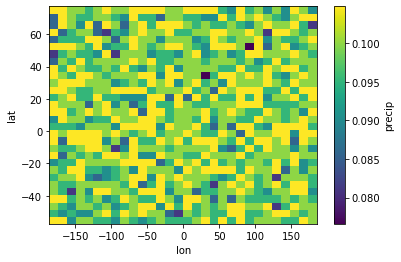

In [32]:
runs = event_detector.calculate_runs()
runs.mean(dim='time').plot()

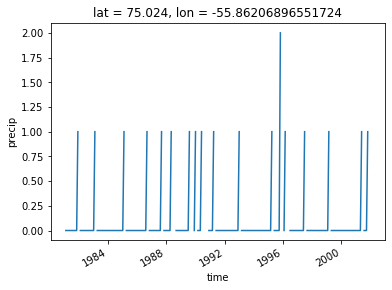

In [33]:
runs.isel(lat=-1, lon=-20).plot()

## Indices

Implemented a number of precipitation based indices that could nonetheless also be used for other variables:

- SPI
- ZScoreIndex
- PercentNormalIndex
- DroughtSeverityIndex
- ChinaZIndex
- DecileIndex
- AnomalyIndex

The docstrings will have references and information on the calculation of the indices.

### Index API

These have a similar API. 

The index object has to be initialised with a `Path` object with the path to the data to be analysed.

The major function is `index.fit()` which writes the fitted object to the attribute `index.index`

In [12]:
indices = [
    analysis.SPI,
    analysis.ZScoreIndex,
    analysis.PercentNormalIndex,
    analysis.DroughtSeverityIndex,
    analysis.ChinaZIndex,
    analysis.DecileIndex,
    analysis.AnomalyIndex,    
]

index = analysis.SPI(filepath)
index

In [15]:
index.fit('precip')

Setting the data_start_year automatically: 1981
Setting the inital timeperiod for calibration manually:
            inital year: 1981
Setting the final timeperiod for calibration manually:
            final year: 2001

---------------
 Fitting SPI3 index
 distribution: gamma
 data_start_year: 1981
 calibration_year_initial: 1981
 calibration_year_final: 2001
 periodicity: monthly
 ---------------

Fitted SPI and stored at `obj.index`


In [16]:
index.index

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 30, time: 252)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2001-12-31
  * lat      (lat) float64 -55.15 -50.66 -46.17 -41.69 ... 66.05 70.54 75.02
  * lon      (lon) float64 -180.0 -167.6 -155.2 -142.8 ... 155.2 167.6 180.0
Data variables:
    SPI3     (time, lat, lon) float64 nan nan nan nan ... 0.5877 -2.079 0.3462

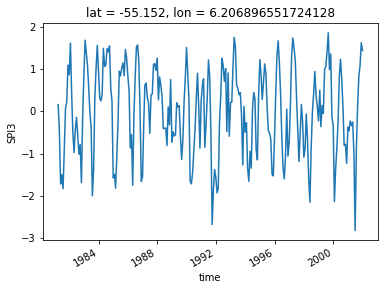

In [34]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

index.index.SPI3.isel(lat=0, lon=15).plot()

## Shapley Values

[See the blog post here:](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83)